In [22]:
from functools import partial
import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import diffrax as dfx  
import optax  
import matplotlib.pyplot as plt
from sklearn import datasets
from tqdm.notebook import trange

from models import ResidualNetwork

In [23]:
def int_beta(t):
    return t


def weight(t): 
    return 1. - jnp.exp(-int_beta(t))  


def single_loss_fn(model, weight, int_beta, data, t, key):
    mean = data * jnp.exp(-0.5 * int_beta(t))
    var = jnp.maximum(1. - jnp.exp(-int_beta(t)), 1e-5)
    std = jnp.sqrt(var)
    noise = jr.normal(key, data.shape)
    y = mean + std * noise
    pred = model(y, t)
    return weight(t) * jnp.mean((pred + noise / std) ** 2)


def batch_loss_fn(model, weight, int_beta, data, t1, key):
    batch_size = data.shape[0]
    tkey, losskey = jr.split(key)
    losskey = jr.split(losskey, batch_size)
    # Low-discrepancy sampling over t to reduce variance
    t = jr.uniform(tkey, (batch_size,), minval=0, maxval=t1 / batch_size)
    t = t + (t1 / batch_size) * jnp.arange(batch_size)
    loss_fn = partial(single_loss_fn, model, weight, int_beta)
    loss_fn = jax.vmap(loss_fn)
    return jnp.mean(loss_fn(data, t, losskey))


@eqx.filter_jit
def single_sample_fn(model, int_beta, data_shape, dt0, t1, key):
    def drift(t, y, args):
        _, beta = jax.jvp(int_beta, (t,), (jnp.ones_like(t),))
        return -0.5 * beta * (y + model(y, t)) 

    term = dfx.ODETerm(drift)
    solver = dfx.Tsit5()
    t0 = 0.
    y1 = jr.normal(key, data_shape)
    # reverse time, solve from t1 to t0
    sol = dfx.diffeqsolve(term, solver, t1, t0, -dt0, y1)
    return sol.ys[0]


@eqx.filter_jit
def make_step(model, weight, int_beta, data, t1, key, opt_state, opt_update):
    loss_fn = eqx.filter_value_and_grad(batch_loss_fn)
    loss, grads = loss_fn(model, weight, int_beta, data, t1, key)
    updates, opt_state = opt_update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    key = jr.split(key, 1)[0]
    return loss, model, key, opt_state


def dataloader(data, batch_size, *, key):
    dataset_size = data.shape[0]
    indices = jnp.arange(dataset_size)
    while True:
        key, subkey = jr.split(key, 2)
        perm = jr.permutation(subkey, indices)
        start = 0
        end = batch_size
        while end < dataset_size:
            batch_perm = perm[start:end]
            yield data[batch_perm]
            start = end
            end = start + batch_size

In [24]:
key = jr.key(0)

model = ResidualNetwork(
    in_size=2, 
    out_size=2, 
    width_size=128, 
    depth=2, 
    y_dim=1, # Just scalar time
    activation=jax.nn.gelu, 
    key=key
)

In [25]:
X, Y = datasets.make_moons(10_000, noise=0.05)
X, Y = jnp.asarray(X), jnp.asarray(Y)[:, jnp.newaxis]

In [26]:
key, train_key, loader_key = jr.split(key, 3) 

t1 = 1.
batch_size = 1000 
lr = 1e-3
num_steps = 100_000

opt = optax.adabelief(lr)
# Optax will update the floating-point JAX arrays in the model.
opt_state = opt.init(eqx.filter(model, eqx.is_inexact_array))

total_value = 0
total_size = 0
with trange(num_steps) as bar:
    for step, x in zip(
        bar, dataloader(X, batch_size, key=loader_key)
    ):
        value, model, train_key, opt_state = make_step(
            model, weight, int_beta, x, t1, train_key, opt_state, opt.update
        )
        bar.set_postfix_str(f"Loss={total_value / total_size:.3E}")

  0%|          | 0/100000 [00:00<?, ?it/s]

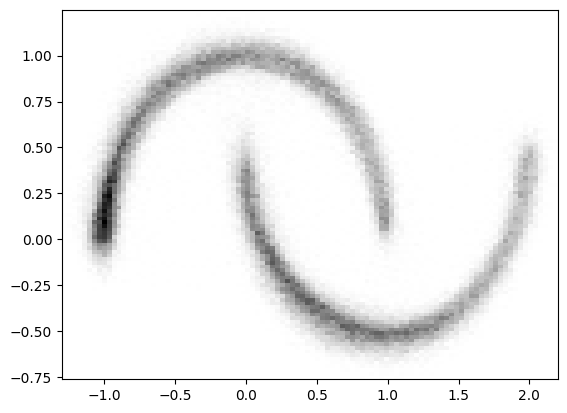

In [29]:
data_shape = X.shape[1:]
dt0 = 0.01
sample_size = 100_000

key, sample_key = jr.split(key)
sample_keys = jr.split(sample_key, sample_size)
sample_fn = partial(
    single_sample_fn, model, int_beta, data_shape, dt0, t1
)
sample = jax.vmap(sample_fn)(sample_keys)

plt.figure()
plt.hist2d(*sample.T, bins=100, cmap="gray_r")
plt.show()

In [28]:
eqx.tree_serialise_leaves("sgm.eqx", model)